# TRAITEMENT D'IMAGES

###### Implementation de FEUJIO Marie Therese 14F2901

## Les differents modules utilises

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image 
import matplotlib.gridspec as gridspec
from matplotlib import cm
import math, sys
import copy

### CASE 1:  PBM

In [4]:
class Pbm:
    def __init__(self,file_path, width=None, heigth=None):
        self.img_name = file_path.split("/")[-1]
        with open(file_path, 'r') as f:
            self.img_flat = f.readlines()
        
        if ("#" in self.img_flat[1]): # Lorsqu'il y a un commentaire
            dimensions = self.img_flat[2].split(" ")
            
        else: #Lorsqu'il y a pas de commentaire
            dimensions = self.img_flat[1].split("")
            
            
        self.width = int(dimensions[0])
        self.heigth = int(dimensions[1].split()[0])
        
        def preprocess(ind):
            for i in range(ind,self.width*self.heigth):
                rm_n = self.img_flat[i].split()
                
                self.img_flat[i] = int(rm_n[0])
            self.img_flat = self.img_flat[ind:]
        
        if ("#" in self.img_flat[1]): # Lorsqu'il y a un commentaire
            preprocess(3)
            
        else: #Lorsqu'il y a pas de commentaire
            preprocess(2)

        self.as_matrix(width = width, heigth= heigth)
        
        print(f""" ABOUT {self.img_name}""".upper())
        self.image_dynamic()
        self.luminance()
        self.contraste_var()
        self.contraste_std()
        self.number_of_bits_used()
        
        fig = plt.figure(constrained_layout=True)
        spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
        
        ax1 = fig.add_subplot(spec[0,0])
        
        ax1.imshow(self.img_matrix, interpolation='nearest', cmap=cm.Greys_r)
        ax1.set_title("The image we will manipulate")
        
            
    def as_matrix(self, structure = None, width=None, heigth=None):
#         img_len = len(self.img_flat)

        if structure is None:
            structure = list(self.img_flat)
#             res = self.img_matrix # By reference
        
        
        if (width is None) or (heigth is None) or (width*height == self.width*self.heigth):
            res = np.array(structure[:-1], dtype=float).reshape((self.heigth, self.width))
        else:
            if width*heigth < self.width*self.heigth:
                print("\nWARNING: Your image will be croped!".upper())
            
                res = np.array(structure[:-1], dtype=float).reshape((width, height)) #[[0 for i in range(width)] for j in range(heigth)]
            else:
                print(f"You want to fill a matrix with {width*heigth}pixels. But the orinal image only has {self.width*self.heigth} pixels.")
                res = np.array(structure[:-1], dtype=float).reshape((self.heigth-1, self.width-1))

        if structure is None:
            return res
        else:
            self.img_matrix = np.array(res) # Just to make sure. TO BE TESTED!
                    
                    
    def binarisation(self, threshold = 126):
        isBinary = True
        for i in range(len(self.img_flat)):
            condition = self.img_flat[i] > 1
            if condition:
                isBinary = False
                img_name = "binarized"+self.img_name
                break
        if not isBinary:
            binarized_img_flat = np.zeros_like(self.img_flat)
            for i in range(len(self.img_flat)):
                
                elt = self.img_flat[i]
                
                condition = int(elt) > threshold
                if condition:
                    binarized_img_flat[i] = 1
                else:
                    binarized_img_flat[i] = 0       
        else:
            print("This image is already in a binary format.".upper())
            return True
            
        my_matrix = self.as_matrix(binarized_img_flat)
        
        self.save(structure= my_matrix, title="Binarized version")


        
    def save(self,structure = None, extension=".pgm", title="The result", xlabel="", ylabel=""):
        
        
        fig = plt.figure(constrained_layout=True)
    
        spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
        
        ax1 = fig.add_subplot(spec[0,0])
        
        function_calling_name = sys._getframe(1).f_code.co_name
        
        if function_calling_name == "histogram":
            if structure is None:
                structure = self.histogram_np
            ax1.plot(structure)
            ax1.set_xlabel(xlabel)
            ax1.set_ylabel(ylabel)
            fig.savefig(f"../results/{extension[1:]}/plot_{self.img_name}.png")
        else:
            if structure is None:
                structure = self.img_matrix
            ax1.imshow(structure, interpolation='nearest', cmap=cm.Greys_r)
            fig.savefig(f"../results/{extension[1:]}/{self.img_name}.png")
        ax1.set_title(title)
        

    def image_dynamic(self):
        """
            Display and return the range of pixels values of this image.
        """
        self.minI, self.maxI=math.inf, 0
        
        for i in range(len(self.img_flat)):
            elt = self.img_flat[i]
            if int(elt) < self.minI:
                self.minI = int(elt)
            if int(elt) > self.maxI:
                self.maxI = int(elt)
       
        print(f"""
                Minimim gray level:  {self.minI}\n
                Maximum gray level:  {self.maxI}
                """)
        
    def intensity_profile(self, row_number, column_start=0, column_end=None):
    
        if column_end is None:
            selected_matrix = self.img_matrix[row_number, column_start:]
        else:
            selected_matrix = self.img_matrix[row_number, column_start:column_end]
            
        self.histogram(signal = selected_matrix)
    
    def histogram(self, signal = None):
        """
        A function shows the distibution of grey levels in an image
    
        Params: 
            my_image: A 2D Array or 3D Array
        
        Return a "plot"
        """
        if signal is None:
            signal = self.img_matrix
        
            # create the histogram
            my_histogram_np, bin_edges = np.histogram(signal, bins=256)
            self.histogram_np = np.copy(my_histogram_np)
        else:
            my_histogram_np, bin_edges = np.histogram(signal, bins=256)
            
            
        
        self.save(structure = my_histogram_np,title=f"Grayscale Histogram of image {self.img_name}", xlabel="grayscale value", ylabel="pixels count")      
        
        
    def luminance(self):
        
        def pixels_sum(img):
            res = 0
            for pixel in img:
                res = res + int(pixel)
            return res, len(img)
        
        # Returns the average of all pixels in the image
        elt = pixels_sum(self.img_flat)
        print(f"""
                The average of all pixels in the image is:  {elt[0]/elt[1]}\n
                """)
        
        self.luminance_value = elt[0]/elt[1]
        
        
    def contraste_var(self):
        # Returns the variation between min. and max. gray levels
        res = (self.maxI - self.minI) / (self.maxI + self.minI)
        print(f"""
                The variation between minimum and maximum gray levels is : {res} \n
            """) 

    def contraste_std(self):
        """
            Returns the standard deviation of the distribution of gray levels.
        """
        self.luminance()
#         print(f"LA BRILLANCE:  {brillance}")
        nrows = len(self.img_flat) #j
        magnitude = 0
        for x in range(nrows):
                magnitude += (int(self.img_flat[x]) - self.luminance_value)**2
        res = ((1 / (self.width * self.heigth)) * magnitude)**(1/2)
        print(f"""
                The standard variation of the distribution of gray levels is: {res} \n
                """)
    
    
    def number_of_bits_used(self):
        res = 1
        self.num_bits = 0
        if self.maxI == 1:
            self.num_bits = 2
        while res <= self.maxI:
            res = res * 2
            self.num_bits += 1
            
        print(f""""
                This image is represented with {self.num_bits} bits \n
        """)

    

 ABOUT LENA.PGM

                Minimim gray level:  19

                Maximum gray level:  255
                

                The average of all pixels in the image is:  116.76902859104693

                

                The variation between minimum and maximum gray levels is : 0.8613138686131386 

            

                The average of all pixels in the image is:  116.76902859104693

                

                The standard variation of the distribution of gray levels is: 49.420098180945516 

                
"
                This image is represented with 8 bits 

        


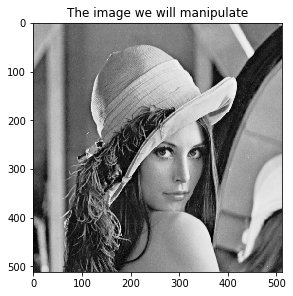

In [5]:
lena = Pbm("../images_test/lena.pgm")



In [10]:
lena.width*lena.heigth

262144

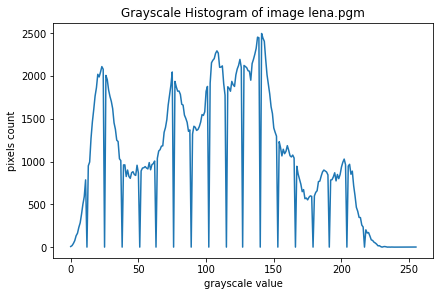

In [5]:
lena.histogram()

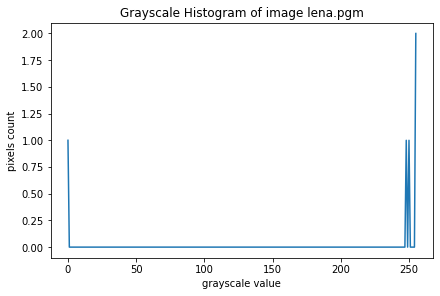

In [6]:
lena.intensity_profile(25, 0, 5)

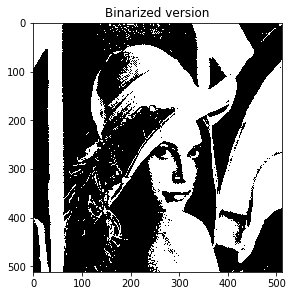

In [7]:
lena.binarisation(125)


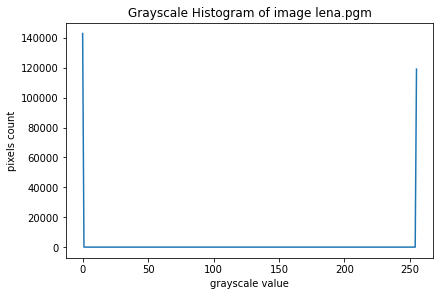

In [8]:
lena.histogram()

 ABOUT TOPO.PGM

                Minimim gray level:  7

                Maximum gray level:  255
                

                The average of all pixels in the image is:  118.72710072172971

                

                The variation between minimum and maximum gray levels is : 0.9465648854961832 

            

                The average of all pixels in the image is:  118.72710072172971

                

                The standard variation of the distribution of gray levels is: 62.35522516822473 

                
"
                This image is represented with 8 bits 

        


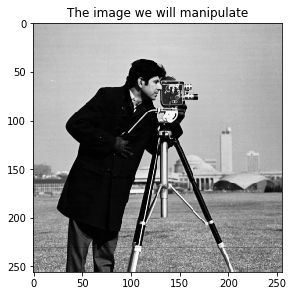

In [11]:
topo = Pbm("../images_test/topo.pgm")


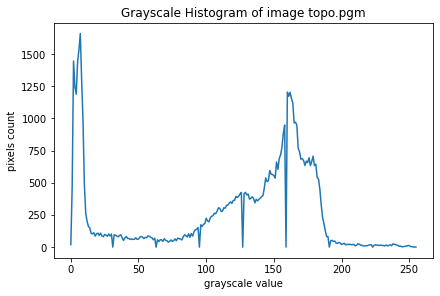

In [12]:
topo.histogram()

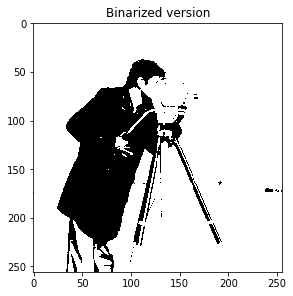

In [13]:
topo.binarisation(25)

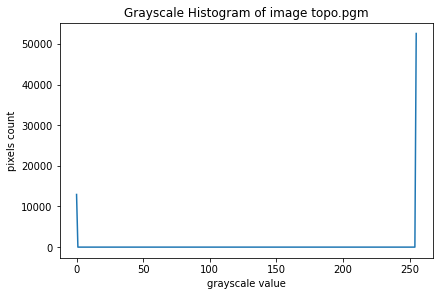

In [14]:
topo.histogram()

## Case 2: PGM

In [11]:
class Pgm(Pbm):
    
    def __init__(self, file_path, width=None, heigth=None):
        super().__init__(file_path, width=width, heigth=heigth)
    
    
    def linear_transformation(self):
        """
            Returns an image processed by a linear function
        """

        x = 2 ** self.num_bits -1
        # LUT initialization
        LUT = []
    
        inv_diff = x / (self.maxI - self.minI)
    
        for i in range(x+1):
            LUT.append( (i - self.minI) * inv_diff)

        new_matrix = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
        
        for i in range(self.heigth):
            for j in range(self.width):
                elt = self.img_matrix[i,j]
                new_matrix[i, j] = int(LUT[int(elt)]) # There a more Pythonic way for doing this.
        
        self.save(structure = new_matrix, extension=".pgm", title="linear_transformmation of "+self.img_name)
        self.histogram(signal=new_matrix)

        
        
    def linear_saturation_transformation(self, Smin, Smax):
        
        if self.minI > Smin:
            raise ValueError(f" Please submit a 'new minimum' level of grey >= 'Old minimum' level of grey ({self.minI}) .")
        if Smax > self.maxI:
            raise ValueError(f" Please submit a 'new maximum' level of grey <= 'Old minimum' level of grey ({self.maxI}) .")
        bits_used = self.num_bits
        x = 2 ** bits_used -1
    
        inv_diff = x / (Smax - Smin)
    
        LUT = []
    
        for i in range(x+1):
            res = (i - Smin) * inv_diff
            if res >= x:
                LUT.append(x)
            elif res <= 0:
                LUT.append(0)
            else:
                LUT.append( res )
        #     print(f"LUT Table:  \n{LUT} \n\n")
    
        
        new_image = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
    
        for i in range(self.heigth):
            for j in range(self.width):
                elt = self.img_matrix[i,j]
                new_image[i, j] = int(LUT[int(elt)]) 
    
#         return new_image

        self.save(structure=new_image, title="linear_saturation_transformation of "+self.img_name)
        self.histogram(signal=new_image)
        print("\nLook at the file linear_saturation_transformation.pgm in your file system.")
        
        
        
    
    def linear_piecewise_tranformation(self, Smin, S, Smax):

        x = 2 ** self.num_bits -1
    
        inv_diff = x / (S - Smin)
    
        condition = (Smin < S) and (S < Smax)
    
        if not condition:
            raise ValueError(f"The value of S: {S} is not correct. it should be in [{Smin}, {Smax}]")

        LUT = []
    
        for i in range(x+1):
            res = (i - S) * inv_diff
            if res >= x:
                LUT.append(x)
            elif res <= 0:
                LUT.append(0)
            else:
                LUT.append( res )
        new_image = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
    
        for i in range(self.heigth):
            for j in range(self.width):
                elt = self.img_matrix[i,j]
                new_image[i, j] = int(LUT[int(elt)])
    
        self.save(structure=new_image, title="linear_piecewise_transformation of "+self.img_name)
        self.histogram(signal=new_image)
        
        
    def non_linear_transformation(self, method = 'gamma correction'):
        
        new_img = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
    
        if method == 'gamma correction':
            param = float(input("Give the value of parameter gamma(an integer please):   "))
            param = 1 / param
        
            for i in range(self.heigth):
                for j in range(self.width):
                    new_img[i, j] = round(self.img_matrix[i, j]**param)
            
        elif method == "log" or method == "logarithmic":
            # S = C log(1 + r)
            param = float(input("Give the value of parameter C:   "))
        
            for i in range(self.heigth):
                for j in range(self.width):
                    new_img[i, j] = round(param * math.log(self.img_matrix[i, j] + 1))
                    
        self.save(structure=new_img, title="linear_piecewise_transformation of "+self.img_name)
        self.histogram(signal=new_img)
        
        
    def histogram_equalizer(self):
    
        # Step 1: compute histogram
#         self.histogram()
        hist = self.histogram_np
    
        # Step 2: Normalize histogram
        nbp = self.width*self.heigth
        hist_norm = hist / nbp
    
        # Step 3: Density of normalised probabilities
        density = np.cumsum(hist_norm)
        
   
        # Step 4: Levels of grey transformation
        new_img = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
        
        for i in range(self.heigth):
            for j in range(self.width):
                ind = self.img_matrix[i, j]
               
                new_img[i, j] = int(nbp * density[int(ind)])
                
                
        self.save(structure=new_img, title="histogram equalization of "+self.img_name)
        self.histogram(signal=new_img)
        
        
    def perform_arithmetic_operations(self, img2 = None, type="+"):
        

        res_img = new_img = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
    
        self.number_of_bits_used()
        bits_used =self.num_bits
        x = 2 ** bits_used -1
        if img2 is None:
            if type == "*":
                ratio = int(input("You are performing a multiplication by ratio: "))
            
                for i in range(self.heigth):
                    for j in range(self.width):
                        new_value = self.img_matrix[i, j] * ratio
                        if new_value > x:
                            res_img[i, j] = 0
                        else: 
                            res_img[i, j] = new_value
                self.save(structure=res_img, title="Multiplication of "+ self.img_name +" in ")
                self.histogram(signal=res_img)
            
            else:
                print("Type of arithmetics cannot be perform. Provide a second image or precise the type as *")
        else:
            
            # Sanity check
            if len(self.img_matrix) != len(img2.img_matrix) or len(self.img_matrix[0]) != len(img2.img_matrix[0]):
                raise ValueError("One can only perform arithmetic operations on images of same shape.")
            if type == "-":
                print("Pay attention: img1-img2 different to img2-img1 ")
            
            if type == "+":
                for i in range(self.heigth):
                    for j in range(self.width):
                        res_img[i, j] = min(self.img_matrix[i, j] + img2.img_matrix[i, j], x)
                self.save(structure=res_img, title="Addition of "+self.img_name+" and "+img2.img_name)
                self.histogram(signal=res_img)
            
                return 0
            elif type == "-":
                for i in range(self.heigth):
                    for j in range(self.width):
                        res_img[i,j] = max(self.img_matrix[i, j] - img2.img_matrix[i, j], 0)
                self.save(structure=res_img, title="Substraction of "+ img2.img_name +" in "+self.img_name)
                self.histogram(signal=res_img)
                return 0
        
            else:
                print("Type of arithmetics cannot be perform.")
    
    
    def perform_logical_operations(self, img2, type = "AND", ratio1=1, ratio2=1):
        
        
        if len(self.img_matrix) != len(img2.img_matrix) or len(self.img_matrix[0]) != len(img2.img_matrix[0]):
                raise ValueError("One can only perform logical operations on images of same shape.")
          
        
        res_img = new_img = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
        norm_coef = ratio1 + ratio2
        self.number_of_bits_used()
        bits_used =self.num_bits
        x = 2 ** bits_used -1
        
        if type == "AND":
            for i in range(self.heigth):
                    for j in range(self.width):
                        combination = (self.img_matrix[i, j]*ratio1 + img2.img_matrix[i, j]*ratio2)/norm_coef
                        res_img[i, j] = min(combination, x)
                        
            self.save(structure=res_img, title="Logical addition of "+self.img_name+" and "+img2.img_name)
            self.histogram(signal=res_img)
            
        elif type == "OR":
            for i in range(self.heigth):
                    for j in range(self.width):
                        combination = max(self.img_matrix[i, j]*ratio1, img2.img_matrix[i, j]*ratio2)
                        res_img[i, j] = min(combination, x)
                        
            self.save(structure=res_img, title="Logical OR of "+self.img_name+" and "+img2.img_name)
            self.histogram(signal=res_img)
        else:
            print("Cannot perform this kind of logical operation. Consider either AND or OR")
        
    def convolution(self, type="roberts"):
        
#         dim = int(input("Enter the dimension of the kernel: "))
        
        res_imgX = new_img = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
        res_imgY = new_img = np.array([0 for _ in range(self.width*self.heigth)]).reshape(self.heigth, self.width)
        
        # How to solve padding
#         if resolve == "mirror":
#             img_matrix = np
        
        # Define the filters
        if type=="gaussian":
#             kernel = np.array([])
            pass
        elif type=="moyenneur":
            pass
        elif type=="median":
            pass
        elif type == "prewitt":
            pass
        elif type == "sobel":
            pass
        elif type == "roberts":
            kernelX = np.array([0, 1, -1, 0]).reshape((2, 2))
            kernelY =  np.array([1, 0, 0, -1]).reshape((2, 2))
            
            dim = 2
            
            for i in range(self.heigth):
                for j in range(self.width):
                    if i - dim >= 0 and j - dim >= 0:
#                       

#                         print(self.img_matrix[i:i+2, j:j+2] )
#                         print(kernelX)
#                         print(kernelY)
#                         return
    
                        res_imgX[i, j] = self.img_matrix[i:i+2, j:j+2] @ kernelX
                        res_imgY[i, j] =  self.img_matrix[i:i+2, j:j+2] @ kernelY
        
                        
            
                    else:
                        res_imgX[i, j] = 0
                        res_imgY[i, j] = 0
                        
            self.save(structure=res_imgX, title="Convolution of "+ img2.img_name +" with Roberts filter on X. ")
            self.histogram(signal=res_imgX)
            
            self.save(structure=res_imgY, title="Convolution of "+ img2.img_name +" with Roberts filter on Y. ")
            self.histogram(signal=res_imgY)
        elif type == "laplacian-min":
            pass
        elif type == "laplacian-max":
            pass
    

 ABOUT MOSQUE.PGM

                Minimim gray level:  39

                Maximum gray level:  255
                

                The average of all pixels in the image is:  191.19542731428638

                

                The variation between minimum and maximum gray levels is : 0.7346938775510204 

            

                The average of all pixels in the image is:  191.19542731428638

                

                The standard variation of the distribution of gray levels is: 33.05872432912614 

                
"
                This image is represented with 8 bits 

        


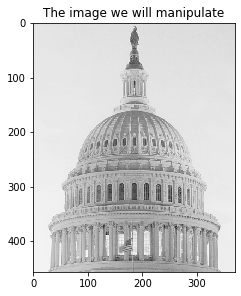

In [12]:
mosque = Pgm("../images_test/mosque.pgm")

In [79]:
mosque.convolution()

ValueError: setting an array element with a sequence.

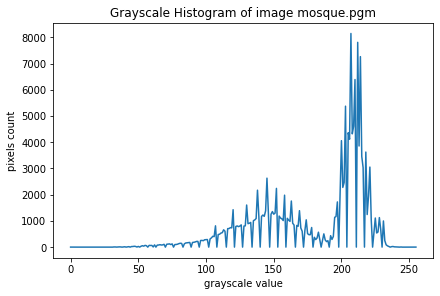

In [18]:
mosque.histogram()

**Interpretation:** L'image est clair et a faible contraste.

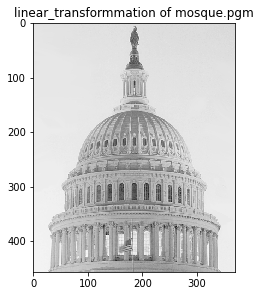

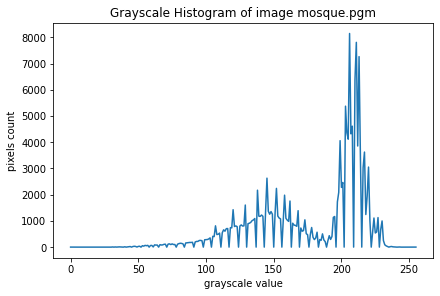

In [13]:
mosque.linear_transformation()


Look at the file linear_saturation_transformation.pgm in your file system.


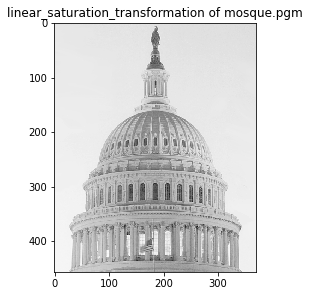

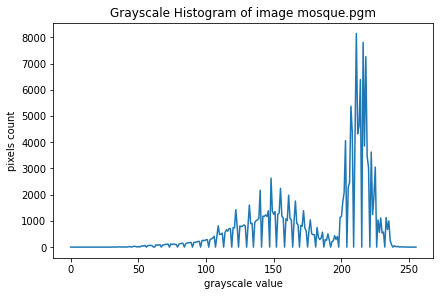

In [20]:
mosque.linear_saturation_transformation(40, 250)

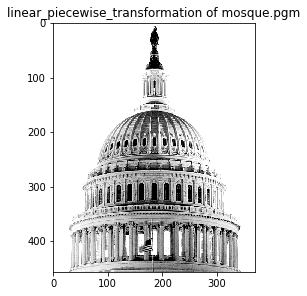

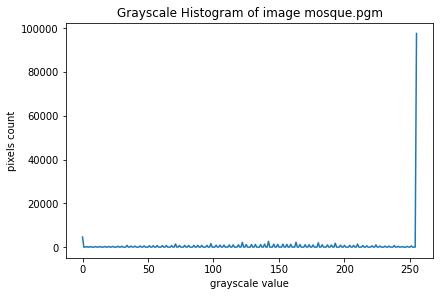

In [21]:
mosque.linear_piecewise_tranformation(Smin = 45, S= 120, Smax=230)

Give the value of parameter gamma(an integer please):    2.5


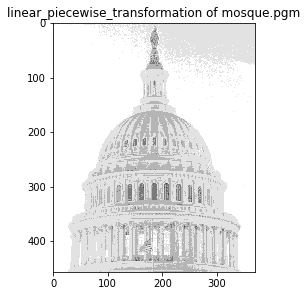

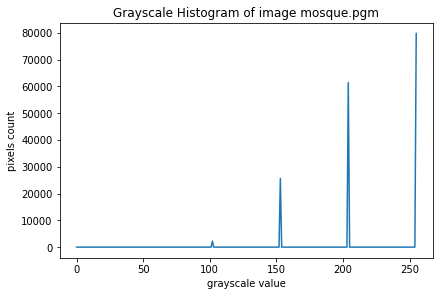

In [22]:
mosque.non_linear_transformation(method = 'gamma correction')

Give the value of parameter C:    10


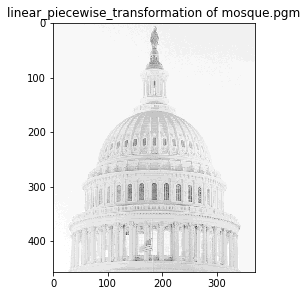

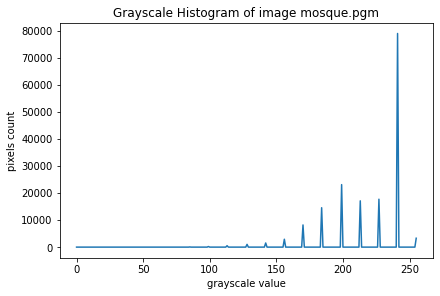

In [23]:
mosque.non_linear_transformation(method = 'log')

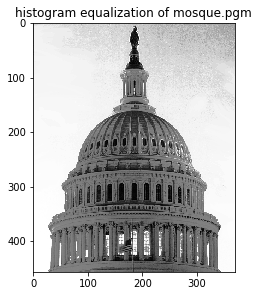

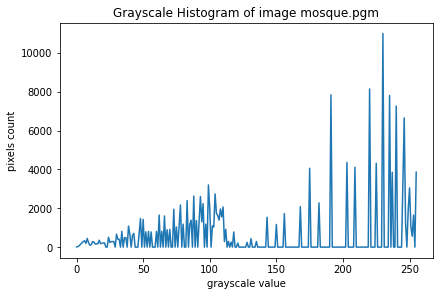

In [24]:
mosque.histogram_equalizer()

"
                This image is represented with 8 bits 

        


0

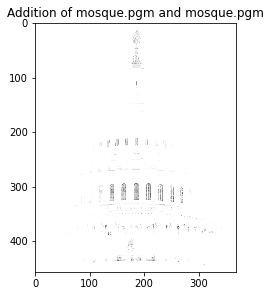

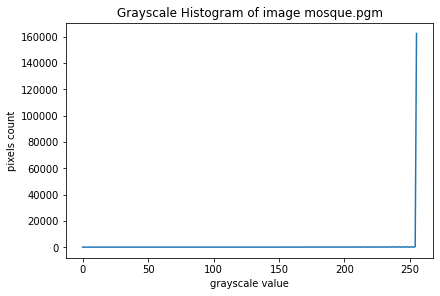

In [25]:
mosque.perform_arithmetic_operations(mosque)

In [20]:
mosque.perform_arithmetic_operations(lena, type="-")

ValueError: One can only perform arithmetic operations on images of same shape.

"
                This image is represented with 8 bits 

        
Pay attention: img1-img2 different to img2-img1 


0

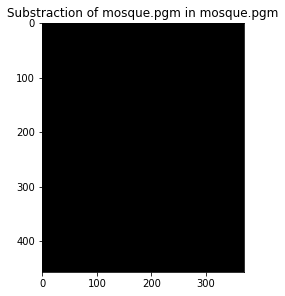

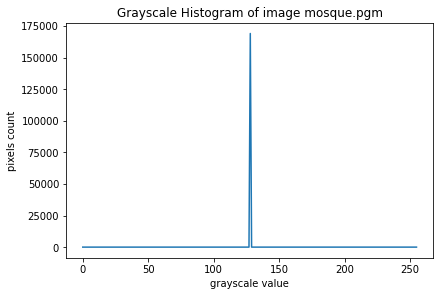

In [26]:
mosque.perform_arithmetic_operations(mosque, type="-")

"
                This image is represented with 8 bits 

        


You are performing a multiplication by ratio:  2


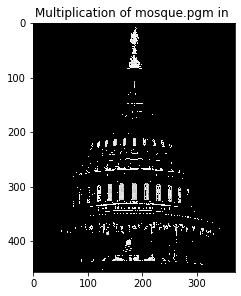

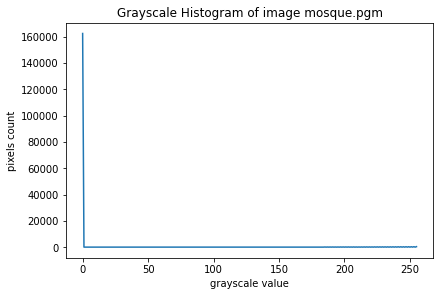

In [28]:
mosque.perform_arithmetic_operations(type="*")

"
                This image is represented with 8 bits 

        


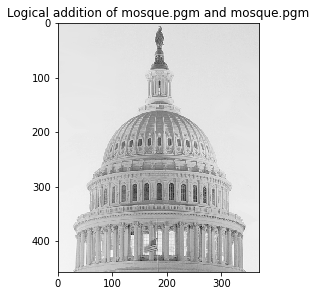

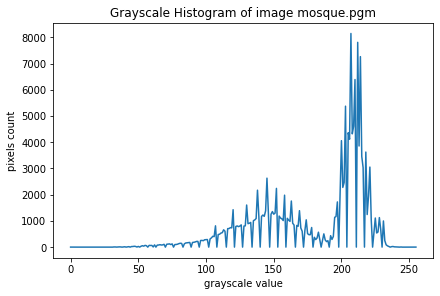

In [31]:
mosque.perform_logical_operations(mosque, type = "AND", ratio1=2, ratio2=1)

On constate que c'est la meme image parce que l'on normalise afin d'eviter que le max ne depasse 255.

"
                This image is represented with 8 bits 

        


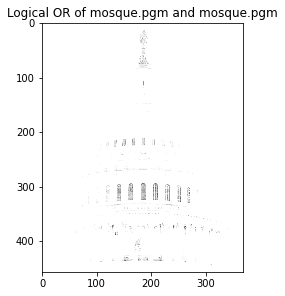

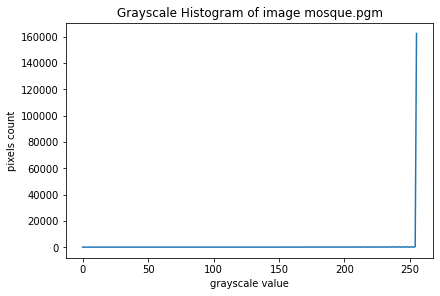

In [54]:
mosque.perform_logical_operations(mosque, type = "OR", ratio1=2, ratio2=1)